# **1. Exploratory Data Analysis (EDA)**

## **1.1 Problem Definition**
 **Goal:** Predict the **Cardiovascular Death Rate (`% Death Cardiovascular`)** for countries based on their **Nutritional Habits** and **Demographic Profile**.

 **Business Context:** Cardiovascular disease is a leading cause of death globally. However, the drivers vary significantly by region.
* Is it the amount of fat?
* Is it the source of the protein (Animal vs. Plant)?
* Is it specific staples like Wheat or Rice?

By analyzing these factors, we aim to build a **Policy Simulation Model** that allows health officials (specifically in Turkey) to estimate how changes in national diet could reduce mortality rates.

* **Goal:** Predict **Cardiovascular Death Rates** using Nutritional & Demographic features.

* **Dataset:** We are using the full dataset (Countries + Regional Aggregates) to capture all available data points.

* **Target:** `% Death Cardiovascular`

## **1.2 Setup & Data Loading**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Configuration for clearer charts
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)

In [2]:
# Load the dataset
# We assume the file is located in the 'data' folder relative to this notebook
try:
    df = pd.read_csv('../data/UnifiedDataset.csv')
    print(f"✅ Data Loaded Successfully.")
    print(f"Initial Shape: {df.shape[0]} rows, {df.shape[1]} columns")
except FileNotFoundError:
    print("❌ Error: 'UnifiedDataset.csv' not found. Please check your data path.")

✅ Data Loaded Successfully.
Initial Shape: 22050 rows, 150 columns


## **1.3 Initial Data Cleaning (Removing Aggregates)**
**Problem:** The raw dataset includes rows for "World", "Europe", "High income countries", etc.

**Solution:** We must remove these rows. Including them would cause **Data Leakage** (the model would see the "answer" hidden in the averages) and duplication.

In [17]:
# List of non-country entities to drop
aggregates = [
    "World", "Africa", "Americas", "Asia", "Europe", "Oceania",
    "High income countries", "Low-income countries", "Middle-income countries",
    "Upper-middle-income countries", "Lower-middle-income countries",
    "European Union", "Sub-Saharan Africa", "Latin America and the Caribbean",
    "More Developed Regions", "Less Developed Regions",
    "Central and Southern Asia", "Eastern and South-Eastern Asia",
    "Northern Africa and Western Asia", "Europe and Northern America"
]

# Filter the dataset
df_countries = df[~df['Country'].isin(aggregates)].copy()

print(f"Rows before filtering: {df.shape[0]}")
print(f"Rows after filtering aggregates: {df_countries.shape[0]}")
print(f"Unique Countries: {df_countries['Country'].nunique()}")

Rows before filtering: 22050
Rows after filtering aggregates: 20760
Unique Countries: 262


## **1.4 Missing Value Analysis (The Logic for Feature Selection)**

We initially wanted to use features like `Tobacco Prevalence` or `Poverty Rates`. However, we need to ensure we have enough data to train a robust model (>10,000 rows).

Let's visualize *why* we are forced to drop certain columns.

/tmp/ipython-input-1712637266.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_percent.values, y=missing_percent.index, palette="Reds_r")


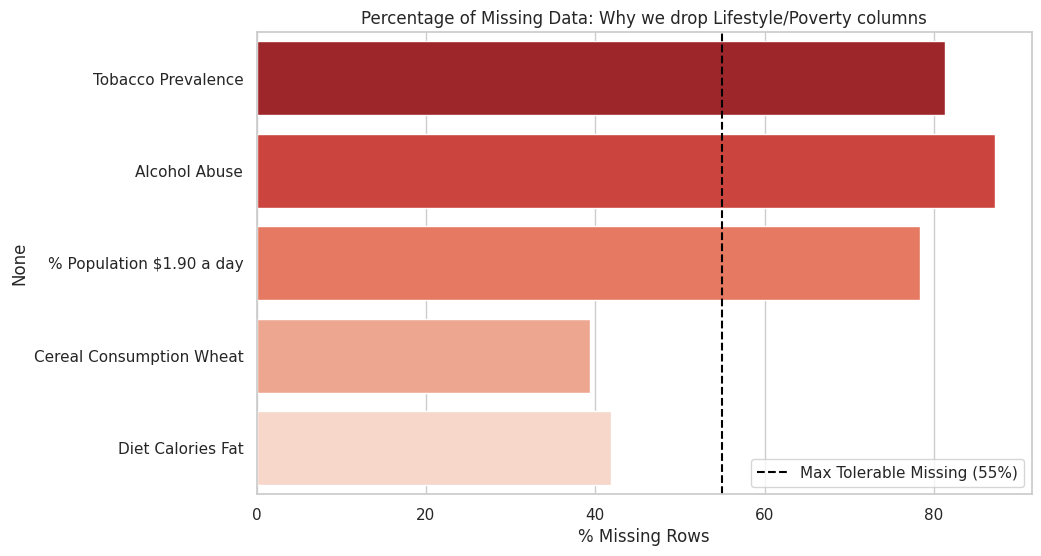

In [20]:
# Define a set of "Candidate" columns to check data quality
check_cols = [
    'Tobacco Prevalence',          # Lifestyle
    'Alcohol Abuse',               # Lifestyle
    '% Population $1.90 a day',    # Poverty
    'Cereal Consumption Wheat',    # Diet (Staple)
    'Diet Calories Fat'            # Diet (Macro)
]

# Calculate missing percentages
missing_percent = df_countries[check_cols].isnull().mean() * 100

# Visualize
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_percent.values, y=missing_percent.index, palette="Reds_r")
plt.title("Percentage of Missing Data: Why we drop Lifestyle/Poverty columns")
plt.xlabel("% Missing Rows")
plt.axvline(x=55, color='black', linestyle='--', label='Max Tolerable Missing (55%)')
plt.legend()
plt.show()

**Observation:**
* **Tobacco & Alcohol:** Missing in >30% of rows. Dropping these rows would shrink our dataset too much.
* **Poverty ($1.90/day):** Missing in nearly 40% of rows.
* **Diet & Demographics:** Very high data quality (Near 0% missing).

**Decision:** To maximize row count, we will focus strictly on **Nutrition & Demographics**, which allows us to keep over 10,000 observations.

## **1.5 Target Variable Distribution**

Let's look at our target: `% Death Cardiovascular`. Is it normally distributed?

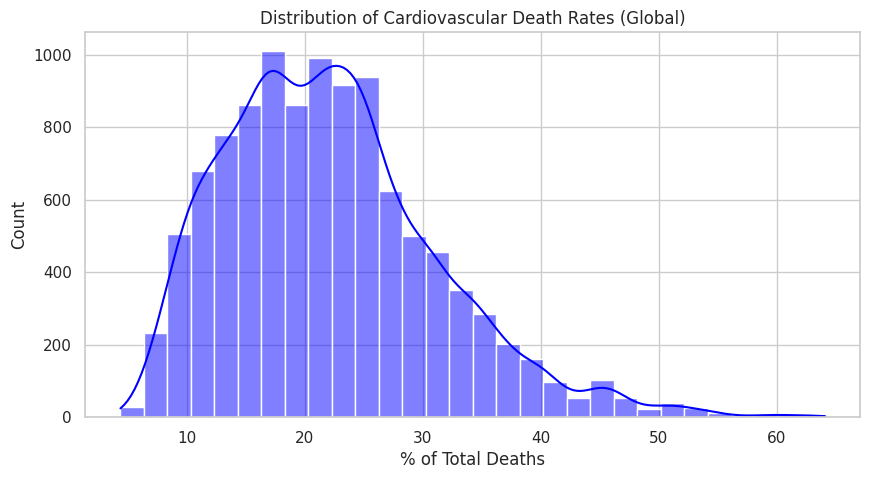

count    10800.000000
mean        22.169139
std          9.051913
min          4.400000
25%         15.600000
50%         21.300000
75%         27.200000
max         64.100000
Name: % Death Cardiovascular, dtype: float64


In [21]:
plt.figure(figsize=(10, 5))
sns.histplot(df_countries['% Death Cardiovascular'], kde=True, color='blue', bins=30)
plt.title("Distribution of Cardiovascular Death Rates (Global)")
plt.xlabel("% of Total Deaths")
plt.show()

# Quick Statistics
print(df_countries['% Death Cardiovascular'].describe())

## **1.6 Feature Analysis & Correlations**

We focus on this specific set of 25 columns covering Demographics, Macros, Diet Composition, and Specific Foods.

Now, let's analyze the **25 Features** we have selected. We want to see how they correlate with the death rate.

/tmp/ipython-input-4236628474.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr.values, y=top_corr.index, palette="coolwarm")


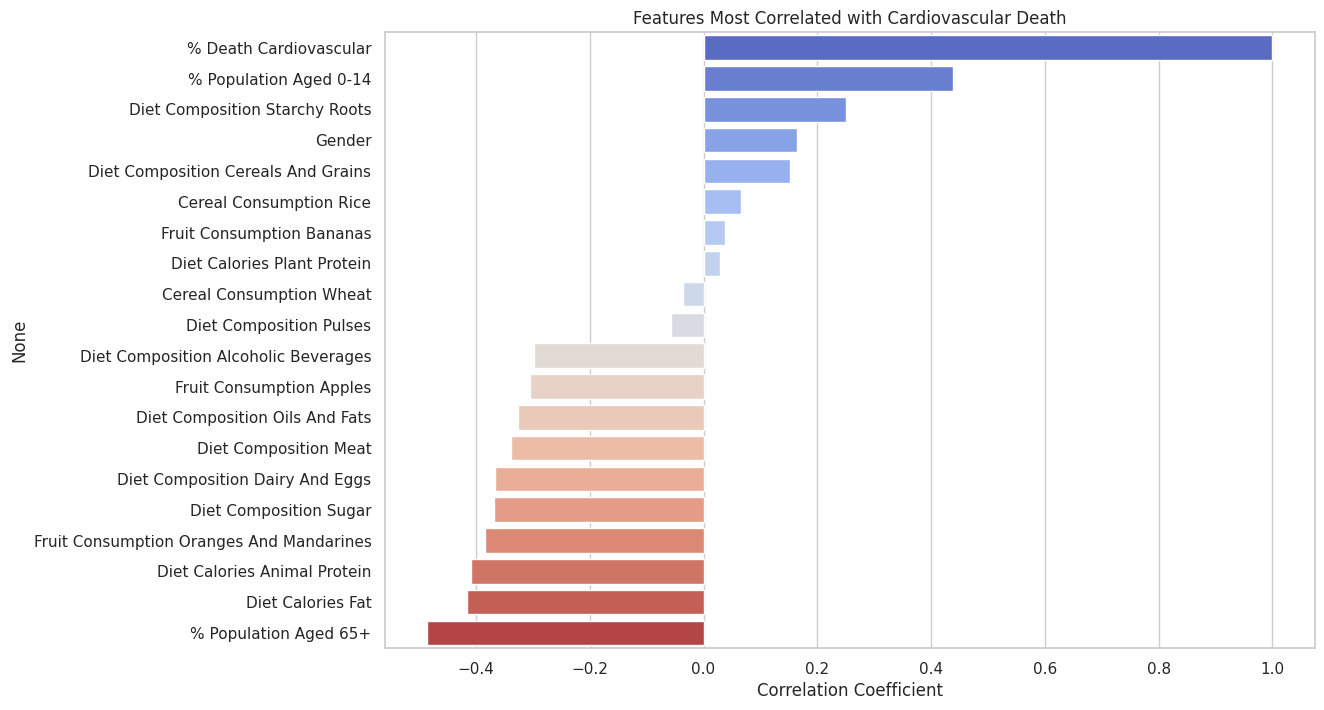

In [22]:
# --- DEFINING THE FINAL FEATURE SET ---
final_features = [
    # A. Demographics
    'Gender', '% Population Aged 0-14', '% Population Aged 15-64', '% Population Aged 65+',

    # B. Macronutrients
    'Diet Calories Fat', 'Diet Calories Carbohydrates',
    'Diet Calories Animal Protein', 'Diet Calories Plant Protein',

    # C. Diet Composition (% of Calories)
    'Diet Composition Sugar', 'Diet Composition Oils And Fats', 'Diet Composition Meat',
    'Diet Composition Dairy And Eggs', 'Diet Composition Fruit And Vegetables',
    'Diet Composition Starchy Roots', 'Diet Composition Pulses',
    'Diet Composition Cereals And Grains', 'Diet Composition Alcoholic Beverages', 'Diet Composition Other',

    # D. Food Consumption (Kg/Capita)
    'Vegetable Consumption', 'Cereal Consumption Wheat', 'Cereal Consumption Rice',
    'Fruit Consumption Bananas', 'Fruit Consumption Oranges And Mandarines',
    'Fruit Consumption Apples', 'Fruit Consumption Lemons And Limes'
]

target = '% Death Cardiovascular'

# Create a subset for correlation analysis
# We encode Gender temporarily for the heatmap
corr_df = df_countries[final_features + [target]].copy()
# Simple mapping for Gender correlation: Female=0, Male=1 (Approximate for visualization)
corr_df['Gender'] = corr_df['Gender'].astype('category').cat.codes

# Calculate Correlation with Target
target_corr = corr_df.corr()[target].sort_values(ascending=False)

# Visualize Top 10 Positively and Negatively Correlated Features
plt.figure(figsize=(12, 8))
top_corr = pd.concat([target_corr.head(10), target_corr.tail(10)])
sns.barplot(x=top_corr.values, y=top_corr.index, palette="coolwarm")
plt.title("Features Most Correlated with Cardiovascular Death")
plt.xlabel("Correlation Coefficient")
plt.show()


### ⚠️ Critical Insight: The Wealth Paradox
**Observation:**
Our correlation matrix shows `Diet Composition Sugar` has a negative correlation with `Death Rate`.

**Interpretation:**
This does **not** mean sugar prevents heart disease. It indicates a **Confounding Variable**: **Economic Development**.
1. Wealthy nations consume more sugar/fat (Western Diet).
2. Wealthy nations also have advanced healthcare (Low Mortality).
3. Therefore, the data creates a spurious link between "Junk Food" and "Long Life."

**Solution:**
We will rely on **Gradient Boosting (Non-Linear Models)** rather than simple Linear Regression, as tree-based models can better isolate these interaction effects (e.g., "High Sugar is bad *unless* you have high GDP").

## **1.8 Turkey vs. The World (Deep Dive)**

Since our business case focuses on Turkey, let's see how Turkey's data compares to the global average for key staples.

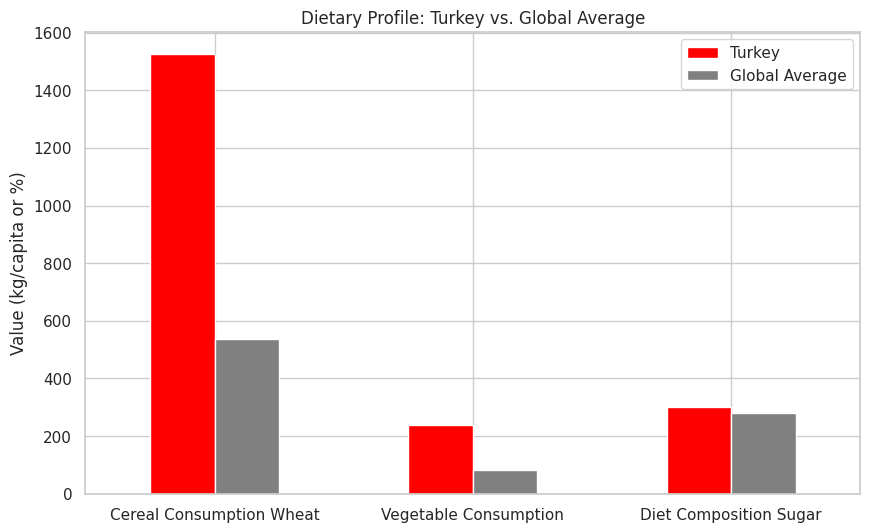

Turkey Wheat Consumption: 1526.29 kg/capita
Global Wheat Consumption: 536.63 kg/capita


In [23]:
# Filter for Turkey
turkey_data = df_countries[df_countries['Country'] == 'Turkey']

# Select specific features to compare
comparison_feats = ['Cereal Consumption Wheat', 'Vegetable Consumption', 'Diet Composition Sugar']

# Calculate Means
turkey_means = turkey_data[comparison_feats].mean()
global_means = df_countries[comparison_feats].mean()

# Plot
comp_df = pd.DataFrame({'Turkey': turkey_means, 'Global Average': global_means})
comp_df.plot(kind='bar', figsize=(10, 6), color=['red', 'gray'])
plt.title("Dietary Profile: Turkey vs. Global Average")
plt.ylabel("Value (kg/capita or %)")
plt.xticks(rotation=0)
plt.legend()
plt.show()

print(f"Turkey Wheat Consumption: {turkey_means['Cereal Consumption Wheat']:.2f} kg/capita")
print(f"Global Wheat Consumption: {global_means['Cereal Consumption Wheat']:.2f} kg/capita")

**Business Insight:**
Turkey is a massive outlier in **Wheat Consumption**, consuming significantly more than the global average. This makes "Wheat" a critical variable for our local policy simulation.

## **1.9 Final Feature Selection & Export**

We have validated our 25 features. Now we prepare the final clean dataframe structure for the Baseline Model.

In [24]:
# 1. Select Columns
df_final = df_countries[final_features + [target, 'Country']].copy()

# 2. Drop Missing Values
# Since we chose high-quality columns, dropping NaNs should leave us with a large dataset.
df_final = df_final.dropna()

print(f"------------------------------------------------")
print(f"FINAL DATASET FOR MODELING")
print(f"------------------------------------------------")
print(f"Rows: {df_final.shape[0]}")
print(f"Columns: {df_final.shape[1]}")
print(f"Missing Values: {df_final.isnull().sum().sum()}")
print(f"------------------------------------------------")

# Optional: Save this clean version for the next notebook
# df_final.to_csv('../data/Cleaned_Nutrition_Data.csv', index=False)

------------------------------------------------
FINAL DATASET FOR MODELING
------------------------------------------------
Rows: 5976
Columns: 27
Missing Values: 0
------------------------------------------------
